In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Flatten,SimpleRNN
import pandas as pd
from ctgan import CTGAN

In [2]:
# Dataset Path
data_path = 'D:/NCI/Sem 3/Thesis/code_DB/dataset'

In [3]:
#classes
class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize lists to hold features and labels
X = []
y = []

# Parameters for feature extraction
n_mfcc = 13  # Number of MFCC features to extract
n_chroma = 12  # Number of chroma features
n_spectral_contrast = 7  # Number of spectral contrast features
max_pad_len = 174  # Ensure all audio files have the same length

In [4]:
def extract_features(file_path):
    """Extract various audio features from a given audio file."""
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    
    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=n_chroma)
    
    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    
    # Extract Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    
    # Pad or truncate features to fixed length
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        chroma = np.pad(chroma, pad_width=((0, 0), (0, pad_width)), mode='constant')
        spectral_contrast = np.pad(spectral_contrast, pad_width=((0, 0), (0, pad_width)), mode='constant')
        mel_spectrogram = np.pad(mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
        chroma = chroma[:, :max_pad_len]
        spectral_contrast = spectral_contrast[:, :max_pad_len]
        mel_spectrogram = mel_spectrogram[:, :max_pad_len]
    
    # Stack features into a single array
    combined_features = np.vstack((mfccs, chroma, spectral_contrast, mel_spectrogram))
    
    return combined_features

In [5]:
# Loop through each class folder and extract features
for i, label in enumerate(class_labels):
    folder_path = os.path.join(data_path, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            features = extract_features(file_path)
            X.append(features)
            y.append(i)  # Store the class label as an integer

In [6]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

X1=X
y1=y

In [7]:
# Reshape X to be suitable for the SVM
X = X.reshape(X.shape[0], -1)  # Flatten the feature array

print(f'Extracted {X.shape[0]} samples with shape {X.shape}')

Extracted 457 samples with shape (457, 27840)


In [8]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy'])

In [17]:
# Initializing the SVM model
svm_model = SVC(kernel='linear')


In [21]:
# Training the SVM model
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [22]:
# Making predictions
y_pred = svm_model.predict(X_test)


In [23]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 58.70%


In [24]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' is used for multi-class scenarios, for binary use 'binary'
print(f'F1 Score: {f1:.2f}')


F1 Score: 0.60


In [25]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')


Precision: 0.62


In [26]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.2f}')

Recall: 0.59


In [14]:
new_row = pd.DataFrame([["SVM (simple)", accuracy]], columns=['Model', 'Accuracy','F1 Score','Precision','Recall'])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df

,Model,Accuracy
0,SVM (simple),0.586957


In [15]:
# Printing classification report
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.79      0.75      0.77        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.59        92
   macro avg       0.16      0.15      0.15        92
weighted avg       0.62      0.59      0.60        92



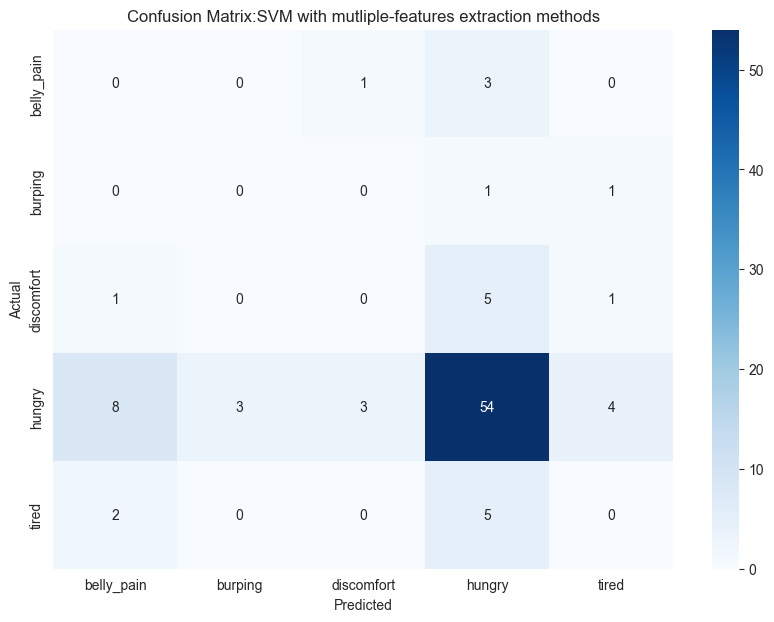

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix:SVM with mutliple-features extraction methods')
plt.show()

In [18]:
# Initializing the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # 



In [19]:
# Training the KNN model on the resampled data
knn_model.fit(X_train, y_train)



KNeighborsClassifier()

In [20]:
# Making predictions
y_pred_knn = knn_model.predict(X_test)


In [21]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 77.17%


In [22]:
new_row = pd.DataFrame([["KNN (simple)", accuracy]], columns=['Model', 'Accuracy'])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df

,Model,Accuracy
0,SVM (simple),0.586957
1,KNN (simple),0.771739


In [23]:
# Printing classification report
print(classification_report(y_test, y_pred_knn, target_names=class_labels))


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.99      0.87        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.77        92
   macro avg       0.16      0.20      0.17        92
weighted avg       0.61      0.77      0.68        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

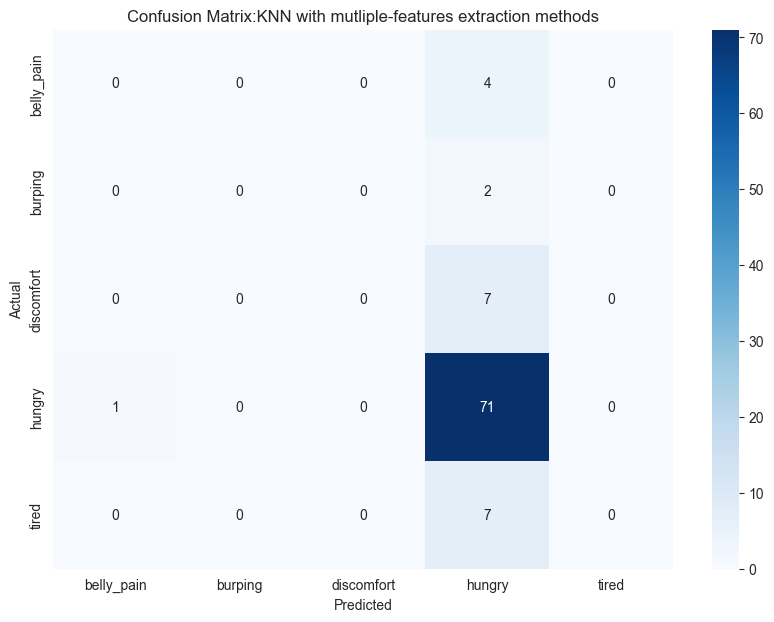

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix:KNN with mutliple-features extraction methods')
plt.show()

In [ ]:
# Initializing the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # 

# Training the KNN model on the resampled data
knn_model.fit(X_train, y_train)

# Making predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy: {accuracy * 100:.2f}%')
new_row = pd.DataFrame([["KNN (simple)", accuracy]], columns=['Model', 'Accuracy'])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df
# Printing classification report
print(classification_report(y_test, y_pred_knn, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix:KNN with mutliple-features extraction methods')
plt.show()

In [10]:
# Reshape X for LSTM (samples, time_steps, features)
X_lstm = X1.reshape(X1.shape[0], X1.shape[2], X1.shape[1])  # (samples, time_steps, features)

In [11]:
# One-hot encode labels
y_lstm = to_categorical(y1, num_classes=len(class_labels))


In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y1)

In [44]:
y_test.shape

(138, 5)

In [43]:
y_train.shape

(319, 5)

In [13]:
# Define the LSTM model
lstm_model = Sequential()

In [14]:
# Add LSTM layer
lstm_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))

In [15]:
# Add another LSTM layer
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.3))

In [16]:
# Add Dense layers
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))

In [17]:
# Output layer with softmax for multi-class classification
lstm_model.add(Dense(len(class_labels), activation='softmax'))

In [18]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
y_test.shape

(138, 5)

In [19]:
# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
10/10 [==============================] - 7s 451ms/step - loss: 1.4051 - accuracy: 0.7743 - val_loss: 0.7533 - val_accuracy: 0.8333
Epoch 2/50
10/10 [==============================] - 4s 406ms/step - loss: 0.8362 - accuracy: 0.8370 - val_loss: 0.6892 - val_accuracy: 0.8333
Epoch 3/50
10/10 [==============================] - 4s 364ms/step - loss: 0.7485 - accuracy: 0.8370 - val_loss: 0.6866 - val_accuracy: 0.8333
Epoch 4/50
10/10 [==============================] - 3s 330ms/step - loss: 0.7175 - accuracy: 0.8370 - val_loss: 0.6807 - val_accuracy: 0.8333
Epoch 5/50
10/10 [==============================] - 3s 330ms/step - loss: 0.7084 - accuracy: 0.8370 - val_loss: 0.6788 - val_accuracy: 0.8333
Epoch 6/50
10/10 [==============================] - 3s 333ms/step - loss: 0.7276 - accuracy: 0.8370 - val_loss: 0.6803 - val_accuracy: 0.8333
Epoch 7/50
10/10 [==============================] - 4s 396ms/step - loss: 0.7415 - accuracy: 0.8370 - val_loss: 0.6756 - val_accuracy: 0.8333
Epoch 

In [20]:
# Evaluate the model
y_pred_lstm = np.argmax(lstm_model.predict(X_test), axis=1)
y_test_lstm = np.argmax(y_test, axis=1)

5/5 [==============================] - 2s 100ms/step


In [21]:
# Accuracy
accuracy = accuracy_score(y_test_lstm, y_pred_lstm)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 83.33%


In [22]:
new_row = pd.DataFrame([["LSTM", accuracy]], columns=['Model', 'Accuracy'])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df

,Model,Accuracy
0,LSTM,0.833333


In [23]:
# Classification report
print(classification_report(y_test_lstm, y_pred_lstm, target_names=class_labels))


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.83      1.00      0.91       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.83       138
   macro avg       0.17      0.20      0.18       138
weighted avg       0.69      0.83      0.76       138



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

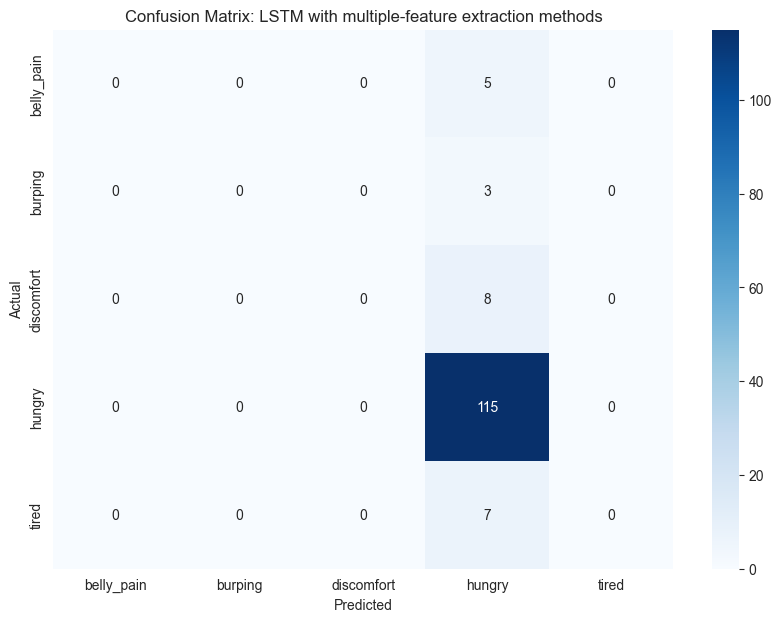

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test_lstm, y_pred_lstm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LSTM with multiple-feature extraction methods')
plt.show()

In [41]:
y_train.shape

(319, 5)

In [39]:
X_test.shape

(138, 174, 160)

In [25]:
X_train.shape

(319, 174, 160)

In [26]:
# Define the RNN model
rnn_model = Sequential()

In [27]:
# Add SimpleRNN layer
rnn_model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
rnn_model.add(Dropout(0.3))

In [28]:
# Add another SimpleRNN layer
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.3))

In [29]:
# Add Dense layers
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dropout(0.3))

In [30]:
# Output layer with softmax for multi-class classification
rnn_model.add(Dense(len(class_labels), activation='softmax'))

In [31]:
# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
# Train the model
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
10/10 [==============================] - 7s 179ms/step - loss: 1.2672 - accuracy: 0.5361 - val_loss: 0.7799 - val_accuracy: 0.8116
Epoch 2/50
10/10 [==============================] - 1s 119ms/step - loss: 0.8106 - accuracy: 0.8245 - val_loss: 0.6969 - val_accuracy: 0.8333
Epoch 3/50
10/10 [==============================] - 1s 115ms/step - loss: 0.7532 - accuracy: 0.8370 - val_loss: 0.7184 - val_accuracy: 0.8333
Epoch 4/50
10/10 [==============================] - 1s 105ms/step - loss: 0.7348 - accuracy: 0.8370 - val_loss: 0.6824 - val_accuracy: 0.8333
Epoch 5/50
10/10 [==============================] - 1s 140ms/step - loss: 0.7581 - accuracy: 0.8307 - val_loss: 0.6896 - val_accuracy: 0.8333
Epoch 6/50
10/10 [==============================] - 1s 124ms/step - loss: 0.7441 - accuracy: 0.8370 - val_loss: 0.6771 - val_accuracy: 0.8333
Epoch 7/50
10/10 [==============================] - 1s 119ms/step - loss: 0.7006 - accuracy: 0.8339 - val_loss: 0.6833 - val_accuracy: 0.8333
Epoch 

In [34]:
# Evaluate the model
y_pred_rnn = np.argmax(rnn_model.predict(X_test), axis=1)
y_test_rnn = np.argmax(y_test, axis=1)

5/5 [==============================] - 0s 16ms/step


In [35]:
# Accuracy
accuracy = accuracy_score(y_test_rnn, y_pred_rnn)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 83.33%


In [36]:
new_row = pd.DataFrame([["RNN", accuracy]], columns=['Model', 'Accuracy'])
results_df = pd.concat([results_df, new_row], ignore_index=True)
results_df

,Model,Accuracy
0,LSTM,0.833333
1,RNN,0.833333


In [37]:
# Classification report
print(classification_report(y_test_rnn, y_pred_rnn, target_names=class_labels))


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.83      1.00      0.91       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.83       138
   macro avg       0.17      0.20      0.18       138
weighted avg       0.69      0.83      0.76       138



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

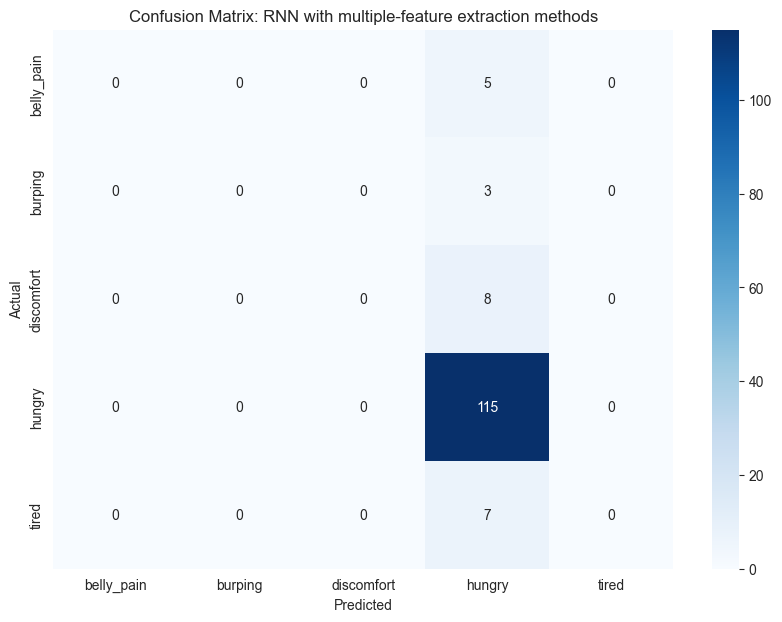

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_test_rnn, y_pred_rnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: RNN with multiple-feature extraction methods')
plt.show()

## CTGAN  : handling data imbalance by synthetic data generation for minority classes

In [27]:
# Check initial class distribution
print(f"Initial class distribution: {Counter(y)}")

Initial class distribution: Counter({3: 382, 2: 27, 4: 24, 0: 16, 1: 8})


In [28]:
X_flat = X.reshape(X.shape[0], -1)

In [29]:
df_ct = pd.DataFrame()

In [30]:
## Applying CTGAN to generate synthetic data for minority classes ##
df_ct = pd.DataFrame(X_flat)


In [31]:
df_ct.shape

(457, 27840)

In [32]:
y.shape

(457,)

In [33]:
# Add the label column to the DataFrame
df_ct['label'] = y  #  y is a 1D array of size (457,)

# Ensure that 'label' is treated as a categorical column
df_ct['label'] = df_ct['label'].astype('str')#.cat.codes  # Convert labels to int (discrete values)


In [173]:

#df_ct[27842] = y  #  y is a 1D array of size (457,)

# Ensure that 'label' is treated as a categorical column
#df_ct[27842] = df_ct[27842].astype('category').cat.codes  

In [153]:
df_ct['label']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
452    4.0
453    4.0
454    4.0
455    4.0
456    4.0
Name: label, Length: 457, dtype: float64

In [34]:
# Check initial class distribution
print(f"Initial class distribution: {Counter(y)}")

Initial class distribution: Counter({3: 382, 2: 27, 4: 24, 0: 16, 1: 8})


In [39]:
# Initialize CTGAN model
ctgan = CTGAN(epochs=5, verbose=True)#epochs=10

In [40]:
print(df_ct.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '27831', '27832', '27833', '27834', '27835', '27836', '27837', '27838',
       '27839', 'label'],
      dtype='object', length=27841)


In [41]:
df_ct['label']

0      0
1      0
2      0
3      0
4      0
      ..
452    4
453    4
454    4
455    4
456    4
Name: label, Length: 457, dtype: object

In [42]:
df_ct = df_ct.dropna()

In [43]:
#df_ct.rename(columns={'label':27842}, inplace=True)

In [44]:
df_ct.columns=df_ct.columns.astype(str)

In [45]:
# Fit the CTGAN model on the entire dataset
ctgan.fit((df_ct)) # abs(df_ct)

KeyboardInterrupt: 

In [ ]:
#https://sustainabilitymethods.org/index.php/How_To_Create_Synthetic_Data_with_CTGAN

In [144]:
print(df_ct.dtypes)

0        float64
1        float64
2        float64
3        float64
4        float64
          ...   
27836    float64
27837    float64
27838    float64
27839    float64
label    float64
Length: 27841, dtype: object
